# here we will find the parameters of gaussian function
$$
N(\mu, \sigma)
$$
such that it fits the another distribution (with $\mu=3$, $\sigma=2$). We will minimize the negative log-likelihood (or maximize the positive log-likelihood). Why log-likelihood, and not simply likelihood? Because in that case we would have to multiply the probabilities, and it is less convenient than summing the logs of those probabilities:

$$
likelihood = \prod_{i=1}^N P(x_i|\mu, \sigma)
$$

$$
loglikelihood = -\sum_{i=1}^N \log P(x_i|\mu, \sigma)
$$

We need to maximize the log-likelihood to get the best match of our model (gaussian function) parameterized by $\mu$ and $\sigma$. This can be done easily in PyTorch.

The intuitive way to see why it works, imagine that your model is just a normal distribution 

$$
N(\mu, \sigma) ={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}
$$
with mean 0 and standard deviation 1. If take a bunch of data sample from another distribution (say with mean 10 and standard deviation 1), you will have almost zero overlap between these distributions. You can even calculate the log-likelihood by plugging the data points into the $N(\mu=0,\sigma=1)$, gettign the probability for each data point and then summing the resulting probabilities.

see https://www.coursera.org/lecture/bayesian-methods-in-machine-learning/gaussian-mixture-model-LyAxY


In [210]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [211]:
def N(x, m, s):
    pi = torch.tensor(np.pi, dtype=torch.float)
    return 1/(s*torch.sqrt(2*pi))*torch.exp(-0.5*((x-m)/s)**2)

Text(0.5, 1.0, 'Log-likelihood: 7759.45')

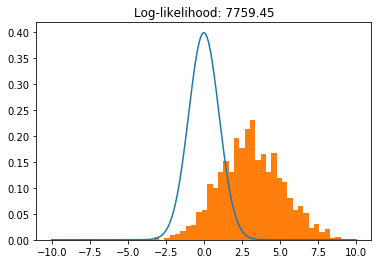

In [212]:
n = 1000

target_m = 3.0
target_s = 2.0

m = Variable(torch.tensor(0, dtype=torch.float), requires_grad=True)
s = Variable(torch.tensor(1, dtype=torch.float), requires_grad=True)

x = torch.linspace(-10, 10, n)
y_hat = N(x, m, s)

ndist = torch.distributions.Normal(torch.tensor([target_m]), torch.tensor([target_s]))
y = ndist.sample((n,)).flatten()

loglikelihood = -torch.log(N(y, m, s)).sum()

plt.plot(x, y_hat.detach().numpy())
tt = plt.hist(y.detach().numpy().flatten(), bins=35, density=True)
plt.title('Log-likelihood: {:.2f}'.format(loglikelihood.item()))

In [213]:
M, S = [],[]
optimizer = optim.Adam([m, s], lr=0.01)
for i in range(1000):
    optimizer.zero_grad()
    y = ndist.sample((n,)).flatten()
    loglikelihood = -torch.log(N(y, m, s)).sum()
    loglikelihood.backward(retain_graph=True)
    M.append(m.data.item())
    S.append(s.data.item())
#     m.data -= 0.01 * m.grad.data # to update a tensor, you can access in DIRECTLY via w.data.
#     s.data -= 0.01 * s.grad.data # to update a tensor, you can access in DIRECTLY via w.data.
#     m.grad.data.zero_() # we zero out the gradient AFTER we do backprop
#     s.grad.data.zero_() # we zero out the gradient AFTER we do backprop
    optimizer.step()


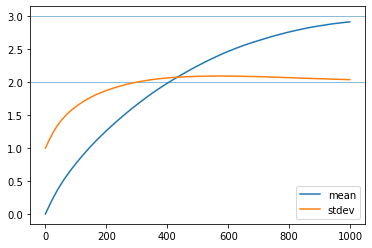

In [214]:
plt.plot(M, label='mean')
plt.axhline(target_m, linewidth=0.5)
plt.axhline(target_s, linewidth=0.5)
plt.plot(S, label='stdev')
plt.legend()

Text(0.5, 1.0, 'Log-likelihood: 2089.54')

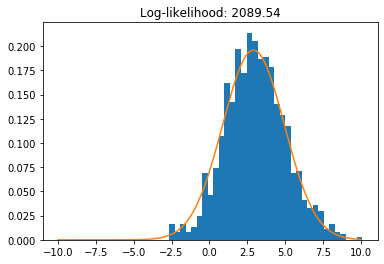

In [215]:
ndist = torch.distributions.Normal(torch.tensor([target_m]), torch.tensor([target_s]))
y = ndist.sample((n,)).flatten()
tt = plt.hist(y.detach().numpy().flatten(), bins=35, density=True)
plt.plot(x, N(x, m, s).detach().numpy())
plt.title('Log-likelihood: {:.2f}'.format(loglikelihood.item()))

$$
p(x|\theta) = \mathcal N(x|\mu, \Sigma)
$$
$$
\theta = \{\mu, \Sigma\}
$$

What $p(x|\theta)$ means is what is the probability that data point $x$ came from a model (in our case it is just a normal distribution) with parameters $\theta$. 

You can also sum a few Gaussians. $\pi$ are needed to scale the distributions such that their sum is 1. If we have trained a model (GMM), we can predict the cluster by seeing which gaussian gives the maximum likelihood.

<tr>
    <td> <img src="./img/GMM_1.png" alt="Drawing" style="width: 300px;"/> </td>
    <td> <img src="./img/GMM_2.png" alt="Drawing" style="width: 300px;"/> </td>
</tr>

So to train this model, we need to find the set of parameters $\theta$

## Training a GMM

The best way to train a GMM is to use the MLE method:

$$
\max_{\theta} {P(X|\theta)}
$$

i.e. we vary $\theta$ to maximize the likelihood of dataset $X = \{x_1,...x_N\}$ given the parameters of the model $\theta$.

We can factorize the likelihood:
$$
P(X|\theta) = \prod_{i=1}^N P(x_i|\theta) 
$$
and because we have a mixture (sum) of Gaussians, we can expand the above expression:

$$
P(X|\theta) = \prod_{i=1}^N P(x_i|\theta) = \prod_{i=1}^N \bigg[\pi_1 \mathcal N(x_i|\mu_1, \Sigma_1) + \pi_2 \mathcal N(x_i|\mu_2, \Sigma_2) + \pi_3 \mathcal N(x_i|\mu_3, \Sigma_3)\bigg]
$$

Or more compactly:

$$
\begin{equation}
P(X|\theta) = \prod_{i=1}^N P(x_i|\theta) = \prod_{i=1}^N \sum_{j=1}^3 \pi_j \mathcal N(x_i|\mu_j, \Sigma_j)
\tag{1}
\end{equation}
$$

subject to the constraint that:

$\sum_i \pi_i = 1$ and $\Sigma $ is **positive semi-definite** (a covariance matrix, can be, e.g. all zeros)

#### Because of these contraints:
It is difficult or impossible to use SGD to opitmize $\theta$ to maximize (log-)likelihood.

In fact, Eq.1 can be rewritten as:
$$
\begin{equation}
p(x|\theta) = \sum_{c=1}^3 p(x|t=c, \theta)p(t=c|\theta)
\end{equation}

where $p(t=c|\theta) = \pi_c$, and $p(x|t=c, \theta)$ is $\mathcal N(x_i|\mu_c, \Sigma_c)$

# Marginalization
To marginalize $t$ means to sum with respect to all values of $t$.

# If we know the posterior, we can estimate the parameters of the distribution that the data came from.

$$
\begin{equation}
\mu_1 = \frac{\sum_i p(t=1|x_i, \theta) x_i}{\sum_i p(t=1|x_i, \theta)}
\tag{5}
\end{equation}
$$

$$
\begin{equation}
\sigma_1 = \frac{\sum_i p(t=1|x_i, \theta) (x_i - \mu_1)^2}{\sum_i p(t=1|x_i, \theta)}
\tag{6}
\end{equation}
$$

**Explanation**. In the enumerator we weight each data point according to the _posterior probability_ that this data came from Gaussian 1. If the posterior probability is low, the data point does not contribute a lot to the estimation of the parameter ($\mu$ or $\sigma$), and conversely. We rescale the sum by the sum total of the likelihoods.

# If we know the locations and variances of the Gaussians
we can use the Bayes rule to estimate the sources (i.e. **which cluster the data came from**). 

# EM algorithm:

1. Start with 2 randomly placed Gaussians with parameters $\theta$
2. Until convergence repeat:
    
    a) For each point compute $p(t=c|x_i, \theta)$: does $x_i$ look like it came from cluster c?
    
    b) Update Gaussian parameters $\theta$ to fit points assigned to them.

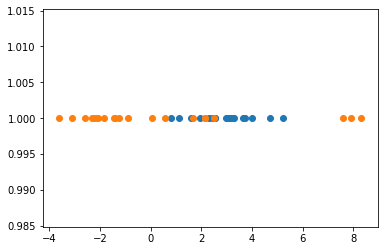

In [93]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x1 = (np.random.randn(20, 1) + 3) * 1
x2 = (np.random.randn(20, 1) + 0) * 3
x3 = np.concatenate((x1, x2))
plt.scatter(x1, np.ones_like(x1))
plt.scatter(x2, np.ones_like(x2))

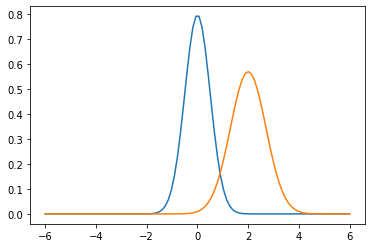

In [99]:
from scipy.stats import norm

theta1 = [0, 0.5]
theta2 = [2, 0.7]

rv1 = norm(loc=theta1[0], scale=theta1[1])
rv2 = norm(loc=theta2[0], scale=theta2[1])
x = np.linspace(-6, 6, 100)
plt.plot(x, rv1.pdf(x))
plt.plot(x, rv2.pdf(x))

0.042083870727363915
2.2961236779397534
0.0
0.0


//anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1720: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


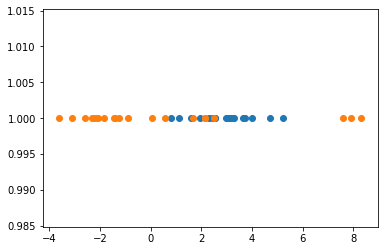

In [104]:
# now lets find the posterior probabilities (that the data comes from distribution 1 or distribution 2):
# p(t=1|x_i, theta1) and p(t=2|x_i, theta2) for the mixed dataset x3
p1 = rv1.pdf(x3)
p2 = rv2.pdf(x3)

# refit the Gaussians using the eqs. 5 and 6:
mu1 = np.sum(p1*x3)/np.sum(p1)
mu2 = np.sum(p2*x3)/np.sum(p2)
print(mu1)
print(mu2)

sigma1 = np.sum(p1*(x3-mu1)**2)/np.sum(p1)
sigma2 = np.sum(p2*(x3-mu2)**2)/np.sum(p2)
print(sigma1)
print(sigma2)

# update the gaussians with new parameters:
rv1 = norm(loc=mu1, scale=sigma1)
rv2 = norm(loc=mu2, scale=sigma2)

plt.scatter(x1, np.ones_like(x1))
plt.scatter(x2, np.ones_like(x2))
plt.plot(x, rv1.pdf(x))
plt.plot(x, rv2.pdf(x))


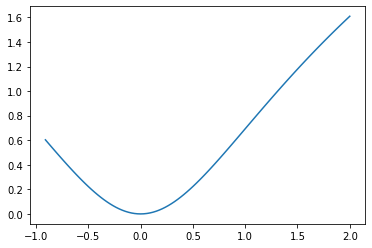

In [5]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-0.91, 2, 100)
y = np.log(1+x**2)
plt.plot(x,y)